In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [8]:
samples_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6_200121_v1"
cut = "lowen_looseVBS"

In [5]:
os.listdir(os.path.join(samples_dir, cut))

['DY_part1.pkl',
 'DY_part2.pkl',
 'DY_part3.pkl',
 'VBS_part1.pkl',
 'Wjets_part1.pkl',
 'background_part1.pkl',
 'models',
 'top_part1.pkl']

In [6]:
samples = {}
for sname in ["VBS", "background"]:
    files = [f for f in os.listdir(os.path.join(samples_dir, cut)) if sname in f]
    for file in files:
        s = pickle.load(open(os.path.join(samples_dir, cut, file), "rb"))
        sname = file.split("_part")[0]
        s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)

        if sname in samples:
            samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
        else:
            samples[sname] = s


In [5]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.XSWeight*df.weight*df.puWeight).sum()*41:15}")

Sample name VBS       , nsamples:     123434,   XS total: 542.9917437296729
Sample name background, nsamples:     522170,   XS total: 176608.83388072244


In [6]:
samples["VBS"].columns

Index(['weight', 'XSWeight', 'Lepton_RecoSF', 'LepWPWeight', 'puWeight',
       'TriggerEffWeight_1l', 'btagSF', 'PrefireWeight', 'events', 'Lepton_pt',
       'Lepton_eta', 'Lepton_phi', 'Lepton_flavour', 'PuppiMET',
       'PuppiMET_phi', 'MET_pt', 'recoMET_pz', 'nJets', 'N_jets_central',
       'N_jets_forward', 'mjj_vbs', 'deltaeta_vbs', 'deltaphi_vbs',
       'vbs_etaprod', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta',
       'vbs_0_phi', 'vbs_1_phi', 'vbs_index_0', 'vbs_index_1', 'mjj_vjet',
       'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'vjet_0_phi',
       'vjet_1_phi', 'vjet_index_0', 'vjet_index_1', 'Zvjets_0', 'Zlep',
       'Asym_vbs', 'Asym_vjet', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww',
       'R_ww', 'R_mw', 'A_ww', 'Centr_vbs', 'Centr_ww', 'nvtx', 'qgl'],
      dtype='object')

In [7]:
## check if there is any event with weight == 0.0
for sname in ["VBS", "background"]:
    print(samples[sname][ samples[sname]["weight"] == 0.0 ])

Empty DataFrame
Columns: [weight, XSWeight, Lepton_RecoSF, LepWPWeight, puWeight, TriggerEffWeight_1l, btagSF, PrefireWeight, events, Lepton_pt, Lepton_eta, Lepton_phi, Lepton_flavour, PuppiMET, PuppiMET_phi, MET_pt, recoMET_pz, nJets, N_jets_central, N_jets_forward, mjj_vbs, deltaeta_vbs, deltaphi_vbs, vbs_etaprod, vbs_0_pt, vbs_1_pt, vbs_0_eta, vbs_1_eta, vbs_0_phi, vbs_1_phi, vbs_index_0, vbs_index_1, mjj_vjet, vjet_0_pt, vjet_1_pt, vjet_0_eta, vjet_1_eta, vjet_0_phi, vjet_1_phi, vjet_index_0, vjet_index_1, Zvjets_0, Zlep, Asym_vbs, Asym_vjet, Mw_lep_reco, Mtw_lep, w_lep_pt, Mww, R_ww, R_mw, A_ww, Centr_vbs, Centr_ww, nvtx, qgl]
Index: []

[0 rows x 56 columns]
Empty DataFrame
Columns: [weight, XSWeight, Lepton_RecoSF, LepWPWeight, puWeight, TriggerEffWeight_1l, btagSF, PrefireWeight, events, Lepton_pt, Lepton_eta, Lepton_phi, Lepton_flavour, PuppiMET, PuppiMET_phi, MET_pt, recoMET_pz, nJets, N_jets_central, N_jets_forward, mjj_vbs, deltaeta_vbs, deltaphi_vbs, vbs_etaprod, vbs_0_pt,

## Samples preparation for NN

In [70]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


In [1]:
import yaml
yaml_vars = yaml.safe_load(open(samples_dir + "/" + cut + "/models/variables.yml"))
print(type(yaml_vars), yaml_vars)
cols = yaml_vars

NameError: name 'samples_dir' is not defined

In [10]:
# cols = ["mjj_vbs", "mjj_vjet", "deltaeta_vbs", "vbs_0_pt", "vbs_1_pt", "vbs_0_eta", "vbs_1_eta", "Lepton_pt", "Lepton_eta", "Lepton_flavour"]
cols = ["mjj_vbs", 
        "vbs_0_pt", "vbs_1_pt", "vbs_0_eta", "vbs_1_eta", 
        "vbs_index_0", "vbs_index_1",
        "deltaeta_vbs", "deltaphi_vbs", 
        "mjj_vjet", 
        "vjet_0_pt", "vjet_1_pt", "vjet_0_eta", "vjet_1_eta", 
        "vjet_index_0", "vjet_index_1", 
        "Lepton_pt", "Lepton_eta", "Lepton_flavour",
        "PuppiMET", 
        "nJets", "N_jets_central", "N_jets_forward", 
        "Zvjets_0", "Zlep", 
        "Asym_vbs", "Asym_vjet", 
        "A_ww", a
        "Mw_lep_reco", "Mtw_lep", "w_lep_pt", "Mww", 
        "R_ww", "R_mw", 
        "Centr_vbs", "Centr_ww",
       ]

In [11]:
X_sig = samples["VBS"][cols].values
X_bkg = samples["background"][cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = samples["VBS"]["weight"].values
W_bkg = samples["background"]["weight"].values

Stack arrays in one only ntuple

In [12]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model_dir = samples_dir + "/" + cut + "/models/"

deltaphi_vbs


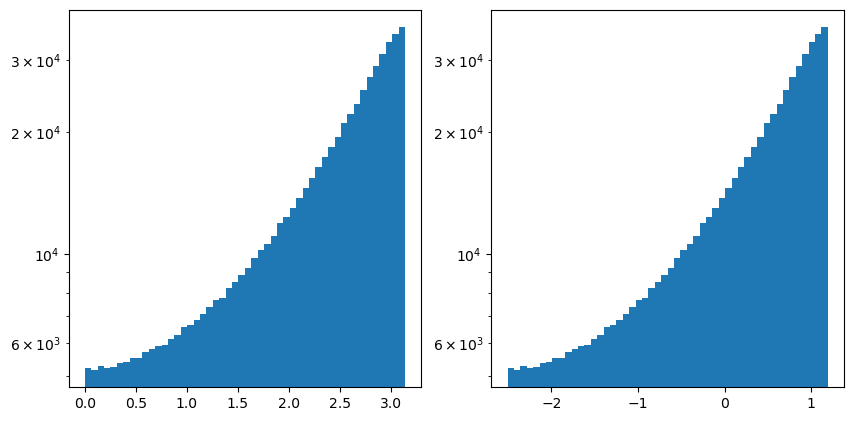

In [40]:
i = 8
print(cols[i])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
ax1.hist(X[:,i], bins=50)
ax1.set_yscale("log")
ax2.hist(X_scaled[:,i], bins=50)
plt.yscale("log")

In [ ]:
import os 
os.makedirs(model_dir, exist_ok=True)
pickle.dump(scaler, open(f"{model_dir}/scaler_model_v0.pkl", "wb"))

In [78]:
den=True

In [80]:
#_ = plt.hist(X[Y==0][:,7], bins=100, density=den, alpha=0.5)
#_ = plt.hist(X[Y==1][:,7], bins=100, color="r", density=den, alpha=0.5)
#plt.yscale("log")
#plt.scatter(X_scaled[Y==1][:,4], X_scaled[Y==1][:,1], c="b")

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [50]:
X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=0.25)
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=0.25)

In [51]:
print("Training dataset: ", X_train.shape)

Training dataset:  (484203, 36)


Create generators to balance signal and background

In [52]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [53]:
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.3))
#model.add(Dense(100, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               3700      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 8,801
Trainable params: 8,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)

In [54]:
history = model.fit_generator(
            training_generator, 
            epochs=100,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = []
            )

Epoch 1/100
764/764 [==============================] - 5s 7ms/step - loss: 0.4001 - acc: 0.7513 - val_loss: 0.3735 - val_acc: 0.7714
Epoch 2/100
764/764 [==============================] - 4s 6ms/step - loss: 0.3774 - acc: 0.7709 - val_loss: 0.3678 - val_acc: 0.7766
Epoch 3/100
764/764 [==============================] - 4s 5ms/step - loss: 0.3725 - acc: 0.7744 - val_loss: 0.3650 - val_acc: 0.7799
Epoch 4/100
764/764 [==============================] - 4s 5ms/step - loss: 0.3697 - acc: 0.7767 - val_loss: 0.3630 - val_acc: 0.7825
Epoch 5/100
764/764 [==============================] - 4s 5ms/step - loss: 0.3676 - acc: 0.7787 - val_loss: 0.3616 - val_acc: 0.7837
Epoch 6/100
764/764 [==============================] - 4s 5ms/step - loss: 0.3664 - acc: 0.7796 - val_loss: 0.3607 - val_acc: 0.7835
Epoch 7/100
764/764 [==============================] - 4s 5ms/step - loss: 0.3650 - acc: 0.7804 - val_loss: 0.3601 - val_acc: 0.7837
Epoch 8/100
764/764 [==============================] - 4s 5ms/step - 

In [55]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test)
auc = roc_auc_score(y_test,pred)
fp, tp, th = roc_curve(y_test, pred)
print("AUC score: " + str(auc))

>>> Computing AUC...
AUC score: 0.8703737647819222


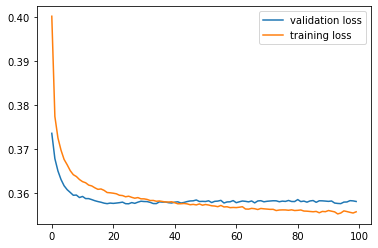

In [56]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

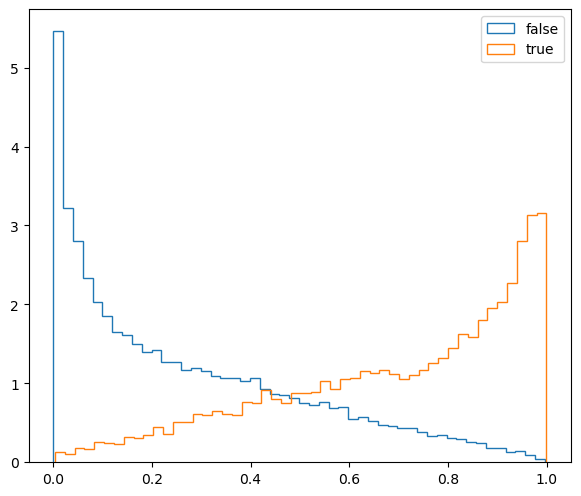

In [59]:
results = model.predict(X_test)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results[y_test==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_test==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_test==1], bins=50, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

In [60]:
samples["background"]["y"] = model.predict(scaler.transform(samples["background"][cols].values))

In [71]:
samples["VBS"]["y"] = model.predict(scaler.transform(samples["VBS"][cols].values))

In [ ]:
results = model.predict(X_test)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
bkg = samples["background"]
plt.hist(bkg[bkg["sample"] == "Wjets"]["y"], bins=50,density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample"] == "top"]["y"], bins=50,density=True, label="top", histtype="step")
plt.hist(bkg[bkg["sample"] == "DY"]["y"], bins=50,density=True, label="DY", histtype="step")
#plt.hist(bkg["y"], bins=50,density=True, label="Tot. bkg", histtype="step")
plt.hist(samples["VBS"]["y"], bins=50,density=True, label="signal", histtype="step")
#plt.hist(results[y_test==0], bins=50,density=True, label="false", histtype="step")
#plt.hist(results[y_test==1], bins=50, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

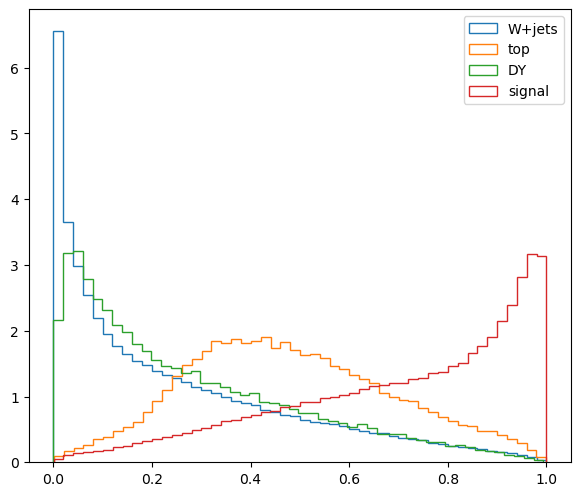

In [74]:
results = model.predict(X_test)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
bkg = samples["background"]
plt.hist(bkg[bkg["sample"] == "Wjets"]["y"], bins=50,density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample"] == "top"]["y"], bins=50,density=True, label="top", histtype="step")
plt.hist(bkg[bkg["sample"] == "DY"]["y"], bins=50,density=True, label="DY", histtype="step")
#plt.hist(bkg["y"], bins=50,density=True, label="Tot. bkg", histtype="step")
plt.hist(samples["VBS"]["y"], bins=50,density=True, label="signal", histtype="step")
#plt.hist(results[y_test==0], bins=50,density=True, label="false", histtype="step")
#plt.hist(results[y_test==1], bins=50, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

(array([4.600e+01, 1.790e+02, 3.910e+02, 5.130e+02, 6.830e+02, 7.790e+02,
        1.046e+03, 1.135e+03, 1.384e+03, 1.758e+03, 2.200e+03, 2.586e+03,
        3.193e+03, 3.558e+03, 4.044e+03, 4.250e+03, 4.232e+03, 3.948e+03,
        3.574e+03, 2.990e+03, 2.444e+03, 2.029e+03, 1.550e+03, 1.089e+03,
        7.830e+02, 5.680e+02, 4.150e+02, 2.840e+02, 1.750e+02, 1.220e+02,
        6.700e+01, 6.000e+01, 4.800e+01, 3.400e+01, 1.100e+01, 1.200e+01,
        8.000e+00, 6.000e+00, 9.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.02267686, 0.07800204, 0.13332722, 0.18865241, 0.24397759,
        0.29930277, 0.35462795, 0.40995313, 0.46527831, 0.52060349,
        0.57592867, 0.63125385, 0.68657903, 0.74190421, 0.79722939,
        0.85255457, 0.90787975, 0.96320493, 1.01853012, 1.0738553 ,
        1.12918048, 1.18450566, 1.23983084, 1.29515602, 1.3504812 ,
        1.40580638, 1.46113156, 1.51

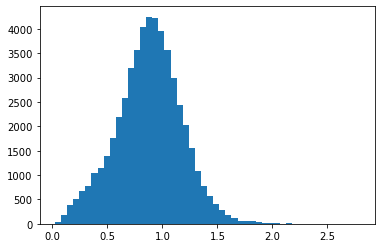

In [83]:
plt.hist(bkg[bkg["sample"] == "DY"]["weight"], bins=50)

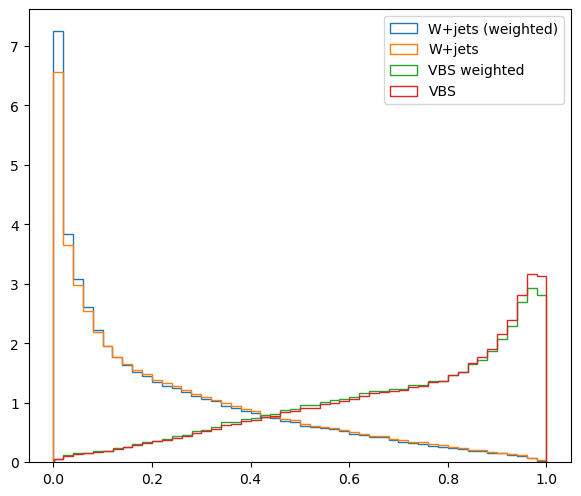

In [79]:
results = model.predict(X_test)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
bkg = samples["background"]
plt.hist(bkg[bkg["sample"] == "Wjets"]["y"],weights=bkg[bkg["sample"] == "Wjets"]["weight"], bins=50,density=True, label="W+jets (weighted)", histtype="step")
plt.hist(bkg[bkg["sample"] == "Wjets"]["y"], bins=50,density=True, label="W+jets", histtype="step")
plt.hist(samples["VBS"]["y"], weights=samples["VBS"]["weight"], bins=50,density=True, label="VBS weighted", histtype="step")
plt.hist(samples["VBS"]["y"], bins=50,density=True, label="VBS", histtype="step")
#plt.yscale("log")
plt.legend()

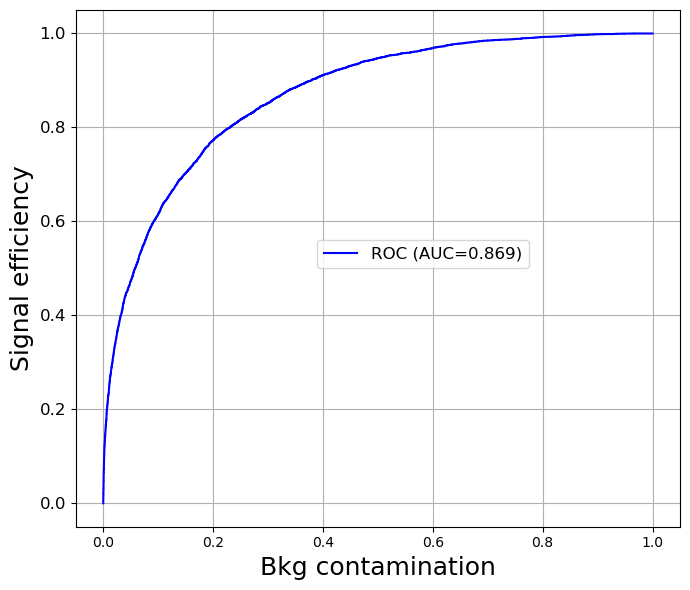

In [48]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()